# Principal Components Analysis: concepts and implementation

Learning objectives:
- Explain what is a principal component and why you want to find them
- Understand how Principal Components Analysis allows us to reduce dimensions while keeping meaningful info
- Understand and apply the concept of projection onto a component.
- Implement PCA using numpy

Note: I am not covering any linear algebra or statistics concepts. To understand what the numpy commands are doing is part of a linear algebra class.

## Introducing drug variation example
Suppose we can make an estimate for every US county, how much of every prescription drug people in that county use, summarized as a number between -10 and 10.  

Here's the data:

In [1]:
dcounty = pd.read_table("hypertension_dXc.txt",sep="\t",index_col=0)
dcounty[:5]

,fosinopril_sodium,nifedipine,guanfacine_hydrochloride,timolol_maleate,indapamide,telmisartan,bisoprolol_fumarate_hydrochlorothiazide,hydrochlorothiazide_valsartan,ramipril,hydrochlorothiazide_telmisartan,...,sotalol_hydrochloride,nadolol,spironolactone,diltiazem_hydrochloride,amlodipine_besylate_atorvastatin_calcium,candesartan_cilexetil,hydrochlorothiazide,hydrochlorothiazide_lisinopril,quinapril_hydrochloride,enalapril_maleate
"Shoshone County,ID",-0.454940,-1.168958,-0.573291,-1.005744,-0.583161,-0.795364,-0.652394,-1.254307,-0.990400,-0.337564,...,-0.579040,-0.640788,0.908147,1.728556,-0.857880,-0.660852,-0.666470,0.584802,-0.672957,-0.144597
"Owyhee County,ID",-0.558984,-1.558048,7.545630,-1.064481,-0.682721,1.295662,-0.771004,-1.468695,-0.467749,-0.911435,...,2.473860,0.138856,1.647155,2.153220,-1.028586,-0.806757,0.315276,0.083571,-0.810820,-0.948102
"Payette County,ID",-0.521203,0.875924,-0.961039,-0.392684,-0.683972,1.702906,-0.758569,0.445125,-0.122698,0.293975,...,-0.694723,-0.800756,1.652662,0.206854,-0.977494,-0.790656,-0.774190,-0.565330,-0.764882,-0.576901
"Yuba County,CA",-0.227786,-0.541012,-0.116298,-0.758539,-1.291350,-0.898334,-1.044147,1.697263,-0.466818,-0.815464,...,0.889064,-0.940327,-0.929866,-0.649223,-1.417226,-0.722287,-0.718461,-0.989108,-1.375841,-0.397373
"Ventura County,CA",0.487167,0.114911,0.799362,-0.202741,-0.524817,-0.823086,-0.837562,-0.084807,0.663132,-1.007134,...,-0.396483,-0.861129,0.873643,-0.440336,-0.458818,0.111003,-1.047407,-1.642750,-0.072682,-1.095683


A drug company hires us to understand the patterns of drug prescription for drugs for **high blood pressure**.  Maybe they want to figure out what factors are driving drug prescription, so they can figure out what county to spend their advertising money for a new drug.

There are 58 different blood pressure drugs-- some are old  and off patent, and some are new and expensive. We can look at the distribution of each of these drugs by themselves:

Text(0, 0.5, 'fraction of counties')

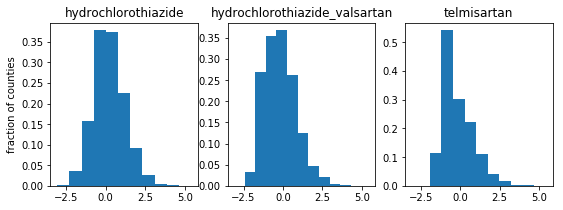

In [94]:
%matplotlib inline
import matplotlib.pyplot as plt
f,ax = plt.subplots(1,3,figsize=(9,3),sharex = True)
for i, drug in enumerate(['hydrochlorothiazide','hydrochlorothiazide_valsartan','telmisartan']):
    ax[i].hist(dcounty[drug],density=True)
    ax[i].set_title(drug)
    
ax[0].set_ylabel("fraction of counties")

So you can see that each county has a number that is:
- near zero if the county has average rate of prescribing, 
- above zero if more prescribing, 
- below zero if less prescribing.

We could look at the counties with most and least use of each drug, but that does not give us much insight into what is going on...

In [3]:
x = dcounty.loc[:,['hydrochlorothiazide','hydrochlorothiazide_valsartan','telmisartan']]
x.sort_values('hydrochlorothiazide',ascending=False)[:10]

,hydrochlorothiazide,hydrochlorothiazide_valsartan,telmisartan
"Accomack County,VA",4.636690,-1.472642,-1.187666
"Decatur County,GA",4.378290,0.222219,0.045416
"Ashland County,WI",3.859079,0.776239,-0.784392
"Jackson Parish,LA",3.808159,-0.746547,3.708361
"Hertford County,NC",3.652178,2.716341,0.769609
"Lincoln County,AR",3.514396,-1.093036,0.726759
"Oneida County,WI",3.491986,-1.696196,-1.088598
"Atoka County,OK",3.351134,1.691641,-0.872104
"Stutsman County,ND",3.292207,0.863402,-0.708730
"Wilson County,NC",3.261563,0.831061,-0.367458


Instead of looking at the variation in prescribing in drugs individually, we can also try to look at the variation in all drugs at the same time. Here red is high (above zero) and blue is low (below zero). So each county has a **58 dimensional vector** of drug use (each row of the figure)

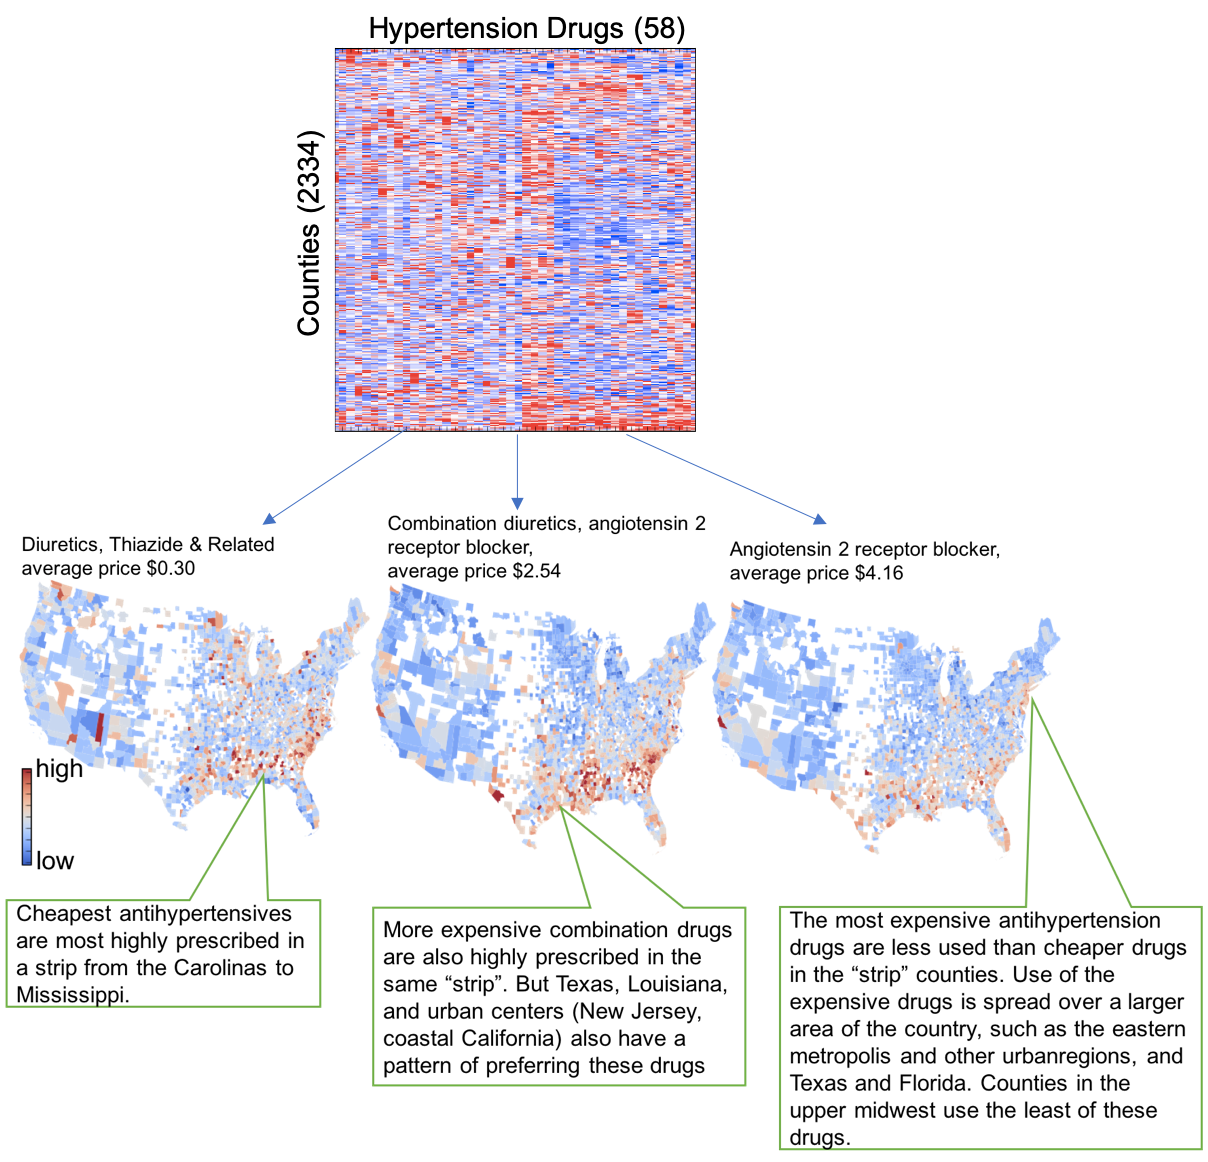

In [10]:
from IPython.display import Image 
Image(filename='variation_hypertensives.png')

If you take a few of the columns and plot the boxes instead on the map of the US (instead of in a column of boxes) you can see there is a pattern in the variation. Which area of the country has highest use of the drug on the left?

We can compare this other things that vary between the counties. Does anyone have a working guess of factors that might determine how much of a drug is used per county?

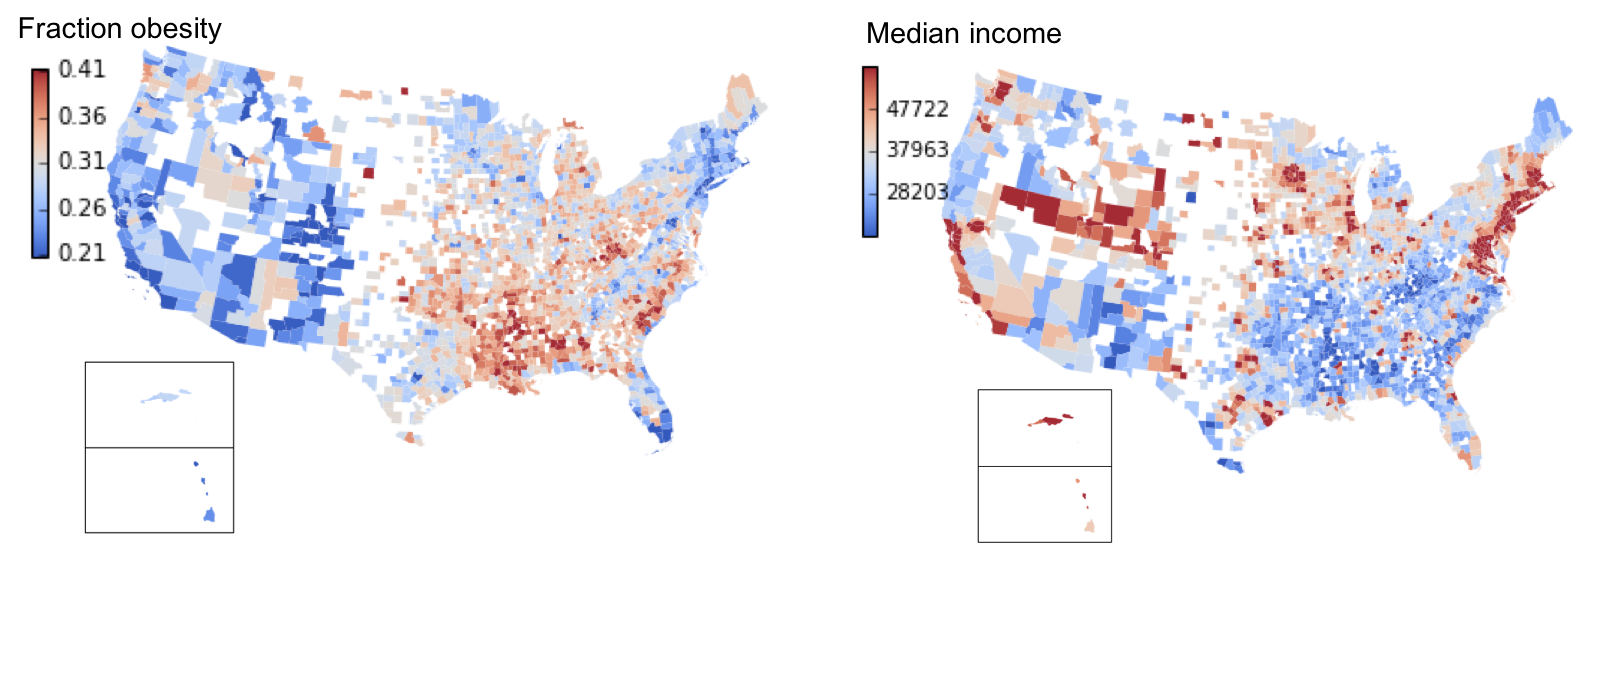

In [15]:
Image(filename='obesity_income.png')

What else do we notice comparing the obesity plot and the income plot?

## Goal: explaining the variation across counties
Each county has a 58 dimensional vector of drug prescription. We want to understand the variation in drug prescription, so we can summarize it and present it to our customers.

Hypothesis: the main **sources of variation** in drug prescription is obesity and income. 

## Let's investigate this by **simulating** some data! 
So if variation in drug prescribing across counties is determined by these 2 characteristics of a county, we can simulate for each county $c$, the prescription of a drug is determined by the rate of obesity in the county, and income in the county using data on obesity and income:

In [5]:
demo = pd.read_table("demographics.txt",sep="\t",index_col = 0) ## normalized version 
demo[:5]

,Adult obesity Value,Median household income Value
"Shoshone County,ID",-0.018052,-0.890590
"Owyhee County,ID",0.244592,-0.738690
"Payette County,ID",0.288366,-0.174957
"Yuba County,CA",-1.112401,-0.504967
"Ventura County,CA",-2.272412,2.176979


We can use these in a formula like:
$$ prescription_c = a \times obesity_c + b \times income_c $$

I simulate a **cheap**, **average**, and **expensive** drug. I'm keeping $a$ = 1 for all three but make 3 coefficients for the income value:
- $b = -.5 $ for cheap drug
- $b = 0 $ for average drug
- $b = .5$ for expensive drug

Here's how you can create values for each drug, if you want the python code:

In [15]:
income_coef = np.array([-.5,0,.5])

x=  np.tile(demo['Adult obesity Value'],(len(income_coef),1)).transpose() +  \
    (demo['Median household income Value']).values.reshape(-1,1).dot((income_coef).reshape(-1,1).transpose())
fdat = pd.DataFrame(x, index= demo.index, columns=['cheap','average','expensive']) 
fdat[:5]

,cheap,average,expensive
"Shoshone County,ID",0.427244,-0.018052,-0.463347
"Owyhee County,ID",0.613937,0.244592,-0.124753
"Payette County,ID",0.375845,0.288366,0.200888
"Yuba County,CA",-0.859918,-1.112401,-1.364885
"Ventura County,CA",-3.360901,-2.272412,-1.183923


Text(0, 0.5, 'expensive')

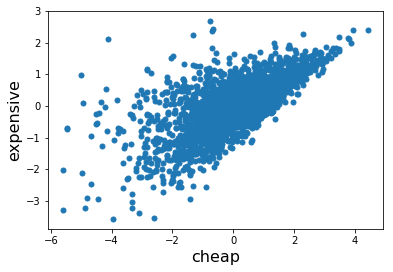

In [35]:
plt.plot(fdat['cheap'],fdat['expensive'],'.',markersize=10)
plt.xlabel("cheap",fontsize=16)
plt.ylabel("expensive",fontsize=16)

Here's the plot for each county of the cheap versus the expensive drug use.  

Each point is a county. 

If you colored each county by its obesity level:
- what would you expect to see? Which counties have the highest obesity?  
- Which counties are richest?


Text(0.5, 1.0, 'colored by income')

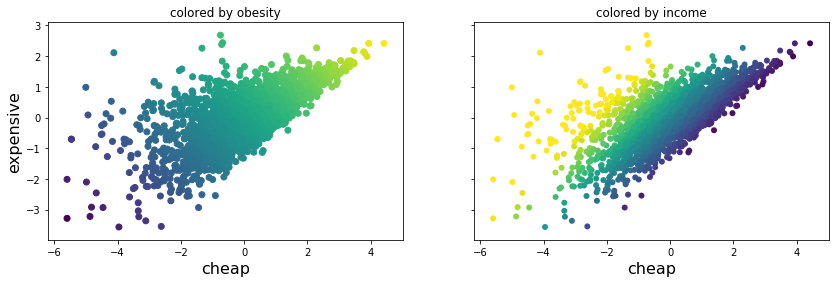

In [35]:
f, ax = plt.subplots(1,2, figsize=(14,4),sharey=True,sharex=True)
ax[0].scatter(fdat['cheap'],fdat['expensive'],c=demo['Adult obesity Value'])
ax[0].set_xlabel("cheap",fontsize=16)
ax[0].set_ylabel("expensive",fontsize=16)
ax[0].set_title("colored by obesity")
ax[1].scatter(fdat['cheap'],fdat['expensive'],c=demo['Median household income Value'],
            linewidth=0,vmax=np.percentile(demo['Median household income Value'],97))
ax[1].set_xlabel("cheap",fontsize=16)
ax[1].set_title("colored by income")
#ax[1].set_ylabel("expensive",fontsize=16)

We'll use this example to discuss 2 important concepts for PCA:
- Components
- Projection onto a component

### Components of variation
We know we could draw two lines that summarize variation in prescribing due to **obesity** and variation in prescribing due to **income**. 

We can call these lines the **components** of variation, and we can sketch the lines related to the cheap and expensive drug levels:

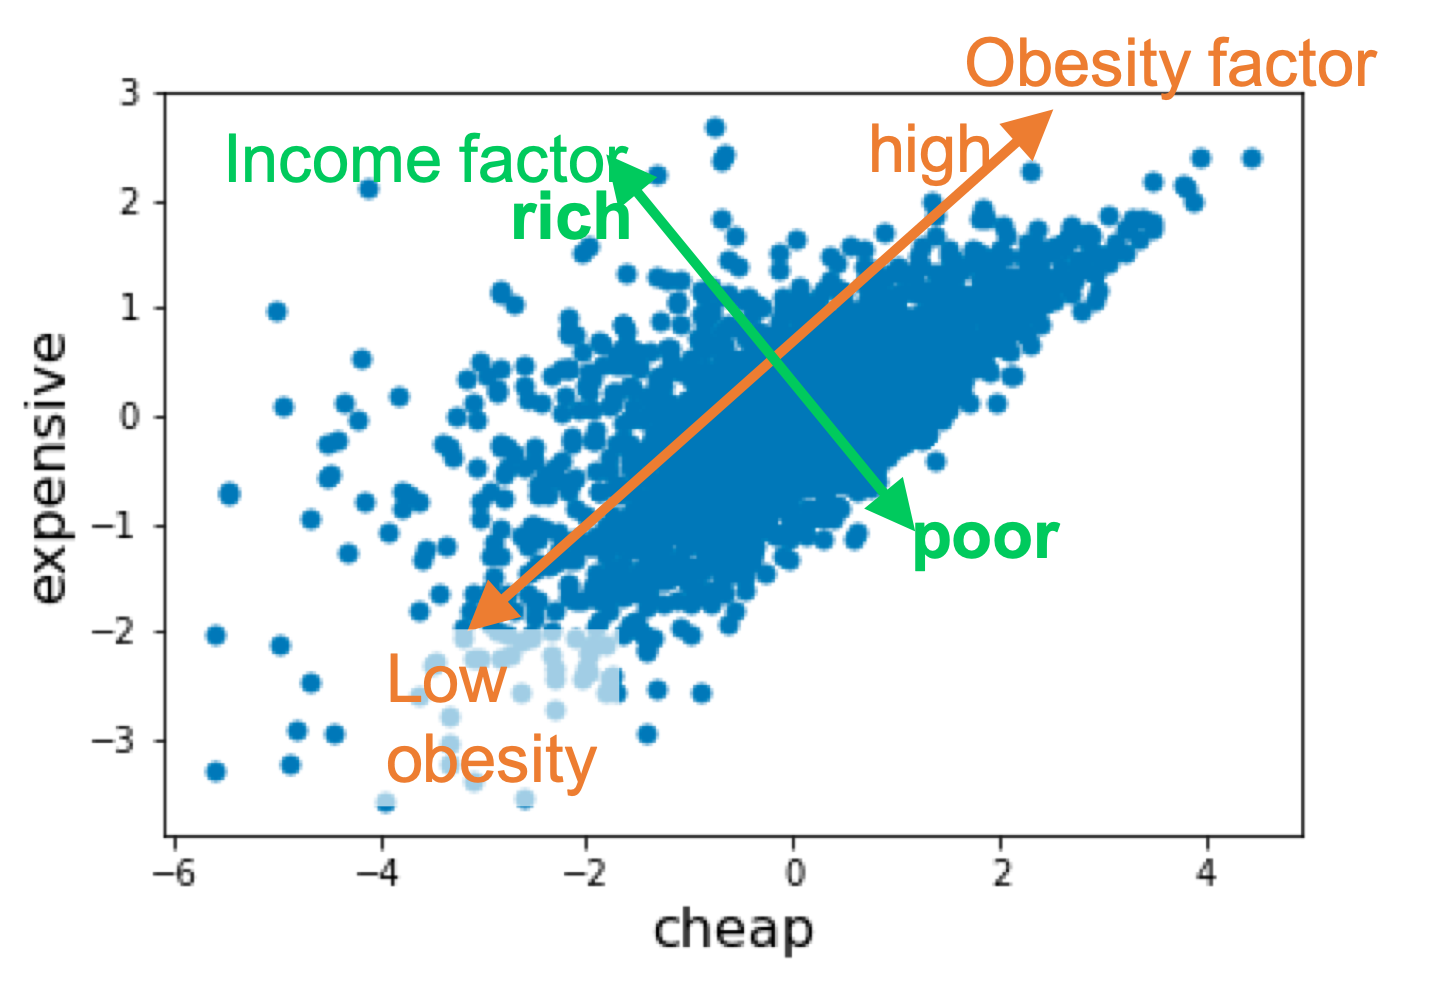

In [20]:
Image(filename='simulated_factors.png',width=470)

We could choose all types of values of $a$ and $b$ to simulate dozens of drugs: but *variation across counties* would still all be a function of these two pieces of information.  

This is the type of pattern we want to discover in our real data!

### Projection onto a Component of variation
*Projection* is a simple mathematical function that takes a point and a line and maps the point onto the closest point that is on the line. We can reduce from three dimensions (cheap, average, expensive) down to two dimensions by projecting each point onto these two components.

We can project each county point onto these two factors:

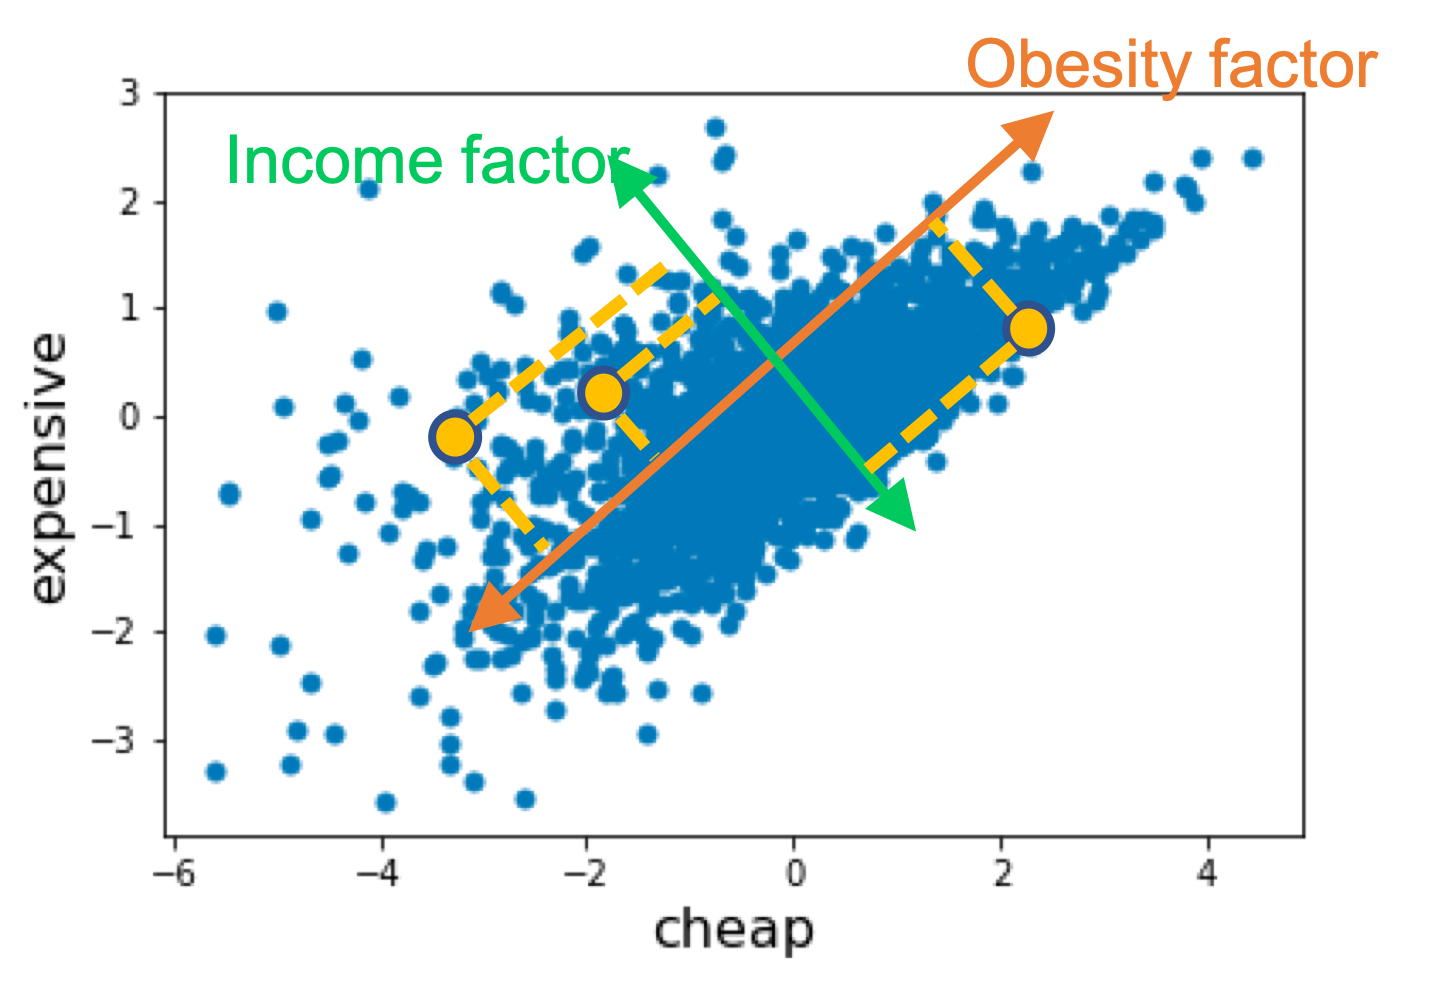

In [19]:
Image(filename='projection_sim.png',width=470)

Think-pair-share: look at the projection of the right-most point highlighted in yellow. Based on the projection, what are the demographic characteristics of that county?

If you tilt your head to the left, you can treat these as a new x-axis and y-axis that actually represent these important variation directions. Here are the actual projections of all the points onto the two components, colored by obesity rate of the county (you can ignore the python code for now...):

Text(0, 0.5, 'income component')

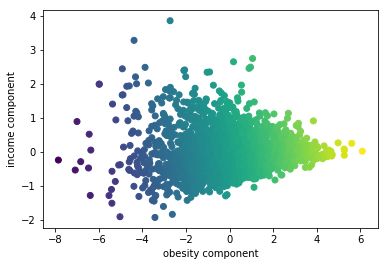

In [97]:
## calculate components
eigen_vals, eigen_vecs = np.linalg.eig(fdat.cov())

## create projections
projections = fdat.dot(eigen_vecs)
plt.scatter(-1*projections[0],projections[1],c=demo['Adult obesity Value'])
plt.xlabel("obesity component")
plt.ylabel("income component")

Notice that after doing projection, there's no more pattern of correlation between the x-axis and y-axis. Projecting onto your top components creates a rotated version of the data so that the x-axis and y-axis capture all the interesting the patterns, and ideally everything else is noise!

## The goal of PCA is to find meaningful ("principal") components automatically
So for non-simulated data, we want some way to find these components.  This has a number of purposes:
- it can allow us to find the patterns in the data. We can evaluate whether my hypothesis is true that the real variation is explained by obesity and income per county.
- it can allow us to compress the meaningful information in the data. Maybe we could represent each county by just obesity and income. This is called **dimensionality reduction** because we can reduce 58 dimensions down to 2 meaningful dimensions. 

### Evaluate your understanding of components: movie data
Take a look at this data set of movie ratings. Each row is a user and each column is their rating of that movie from zero to 5.

In [135]:
ratings = pd.read_csv("movie_rate.csv",index_col=0)
ratings.iloc[:10,:8]

,Toy Story,Jumanji,Frozen,Finding Nemo,Avengers,Iron Man,Black Panther,X-Men
user,,,,,,,,
0,3,2,2,3,3,3,4,2
1,1,1,1,2,5,5,4,4
2,2,1,0,2,0,0,0,0
3,0,2,0,0,2,3,1,2
4,1,2,2,1,1,0,0,1
5,4,5,4,3,4,2,3,4
6,3,3,4,3,2,1,3,2
7,4,5,5,5,0,2,1,1
8,5,4,4,3,2,3,1,3


Discuss: 
- What is the dimensionality of this data?
- What do you think could be the meaningful components of variation?
- Imagine Netflix hired you to analyze this data. What purpose could you use this for?

    
## Using projections to quantify how important a component is

But PCA is not subjective. We can quantify how important a component is, using the projections of the data on to the components. We are looking for the projection with the highest **variance** (it explains most of the  variation in the data) and the lowest **reconstruction error** (the line is closest to the direction of the data. I will explain these ideas

### Variance of projection
Variance is just the spread of points. The animation below [(source)](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues) shows how the variance of the projections varies when you choose different lines to project the points on to.

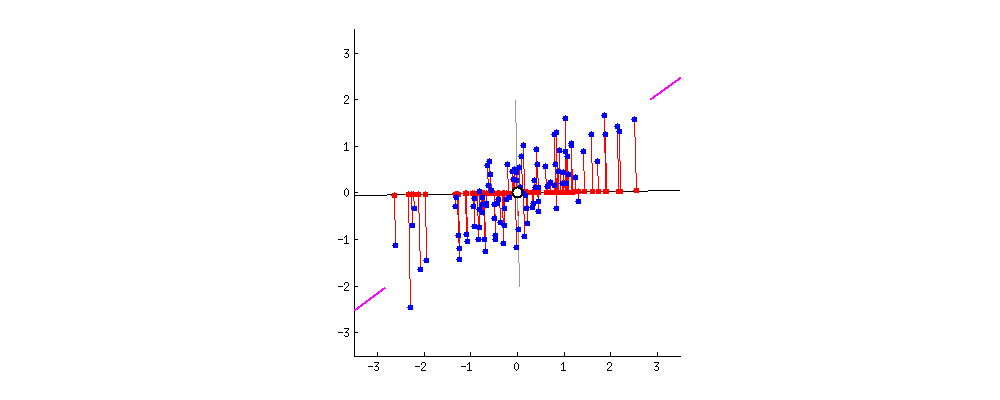

In [100]:
Image(filename='Q7HIP.gif',width=800)

Which line has the highest variance?

### Reconstruction error
Another way to think about the principal component is as the line where if you had to summarize all the data points just with their projections onto the line, and you threw away all the data points, you would have the lowest reconstruction error. 

The errors are represented by the red lines above. What direction looks like it would have the smallest total errors, if you added together all the errors?

### How do we find this line? Using the Covariance Matrix
Now to the part involving statistics and linear algebra! There is a mathematical formula to take your data, and get the principal components. It is implemented in all the major software packages. 

First you calculate the **covariance matrix**: this matrix summarizes for each of our drugs, how wide is the variance, and for each pair of drugs, how related the values are. 

For our fake data you can get the covariance matrix like this: 

In [47]:
fdat.cov()

,cheap,average,expensive
cheap,1.780465,1.265393,0.750321
average,1.265393,1.000429,0.735464
expensive,0.750321,0.735464,0.720607


The entries on the diagonal represent the variance of each drug-- how spread out the values are.  The bigger the value the more spread out:
$$ var_d= { 1\over num. counties } {\Sigma_{c \in counties} (d_c - \bar{d})^2 }$$

The entries off the diagonal are the covariance. This is another simple formula.
$$ cov_{i,j} = { 1\over num. counties - 1} {\Sigma_{c \in counties} (i_c - \bar{i})\times(j_c - \bar{j}) }$$

All three drugs have an average value near zero so $\bar{d}$ is about zero. When `cheap` is greater than zero, is `expensive` more likely to be greater then zero, less than zero, or neither? 

Text(0, 0.5, 'expensive')

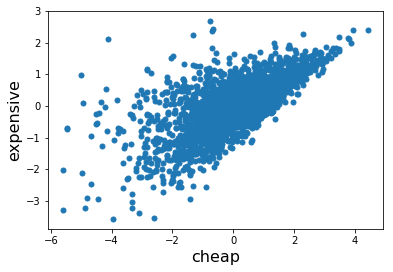

In [103]:
plt.plot(fdat['cheap'],fdat['expensive'],'.',markersize=10)
plt.xlabel("cheap",fontsize=16)
plt.ylabel("expensive",fontsize=16)

What if we simulated the data differently?

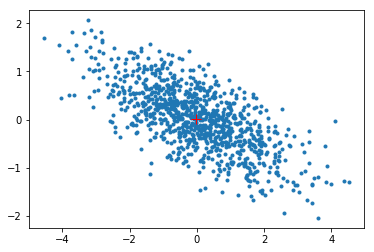

In [121]:
fake2 = pd.read_table("more_fake_data.txt",header=None) 
plt.plot(fake2[0],fake2[1],'.')
plt.plot(fake2[0].mean(), fake2[1].mean(),"+",color='r',markersize=10)
    

Look at the formula for the covariance:
$$ cov_{i,j} = { 1\over num. counties - 1} {\Sigma_{c \in counties} (i_c - \bar{i})\times(j_c - \bar{j}) }$$

Do you think the covariance between $i$ and $j$ is greater than zero or less than zero?

In [76]:
fake2.cov()

,0,1
0,1.005339,-0.520199
1,-0.520199,1.008485


What do you think the top principal component is on this data, using the definition from before, which, remember, is:
- projections on the component maximize the variance explained
- projections on the component minimize the error of reconstruction

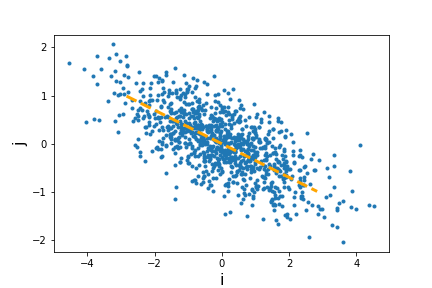

In [123]:
Image(filename='fake_with_component.png',width=400)

So you can see that in this very simple example, the principal component is related to the covariance matrix. Now it's a line with a negative slope. 

But with real data, the covariance matrix will be very big, so you cannot eyeball it. Here our covariance matrix for our real drugs has 58 rows and columns, one for each blood pressure drug..  Here are just first 5 rows and columns

In [78]:
dcounty.cov().iloc[:5,:5]

,fosinopril_sodium,nifedipine,guanfacine_hydrochloride,timolol_maleate,indapamide
fosinopril_sodium,1.000000,0.025091,-0.022424,-0.004501,0.051692
nifedipine,0.025091,1.000000,-0.006177,0.067565,0.030453
guanfacine_hydrochloride,-0.022424,-0.006177,1.000000,0.009562,0.013481
timolol_maleate,-0.004501,0.067565,0.009562,1.000000,0.001953
indapamide,0.051692,0.030453,0.013481,0.001953,1.000000


### Finally, calculating principal components and projections on real data
We are going to use a special function, the eigenvector function, to compute the principal components using the covariance matrix. Eigenvector function finds the top directions represented in the covariance matrix. We aren't going to go into any more detail because as I mentioned this is a topic for linear algebra class. 

So steps to doing PCA are:
1. Calculate covariance matrix
2. Calculate the eigenvectors for the covariance matrix. These are the **components**
3. **Project** your data onto the components by multiplying.

In [124]:
## 1. Covariance matrix
cov_mat = dcounty.cov()

## 2. Calculate components
_, eigen_vecs = np.linalg.eig(cov_mat)

## 3. Create projections
projections = dcounty.dot(eigen_vecs)

Notice this is still a 58-dimensional matrix, but now it's **rotated**:

In [125]:
projections.shape

(2334, 58)

Just like I did above, I'm going to plot the **projections** of each county onto the top 2 components, and then color the counties by obesity, and income, to investigate the relationship:

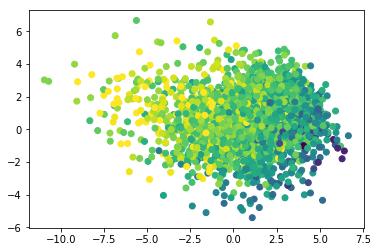

In [93]:
plt.scatter(projections[0], projections[1], c = demo['Adult obesity Value'],
            vmax=np.percentile(demo['Adult obesity Value'],97))

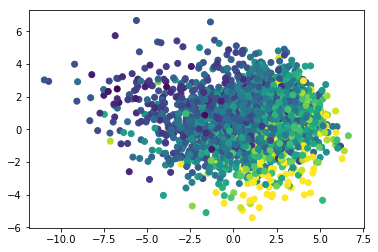

In [27]:
plt.scatter(projections[0], projections[1], c = demo['Median household income Value'],
           vmax=np.percentile(demo['Median household income Value'],97))

## Assessing understanding
Let's go back to the movie example. We additionally have the age of each person

In [134]:
ratings[:10]

,Toy Story,Jumanji,Frozen,Finding Nemo,Avengers,Iron Man,Black Panther,X-Men,age
user,,,,,,,,,
0,3,2,2,3,3,3,4,2,30
1,1,1,1,2,5,5,4,4,29
2,2,1,0,2,0,0,0,0,25
3,0,2,0,0,2,3,1,2,32
4,1,2,2,1,1,0,0,1,30
5,4,5,4,3,4,2,3,4,15
6,3,3,4,3,2,1,3,2,14
7,4,5,5,5,0,2,1,1,12
8,5,4,4,3,2,3,1,3,22


Do the following:
1. Compute PCA on the full data.
2. Plot the points and color by age.
3. Interpret the results.